In [1]:
import collections
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [16]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_images = mnist.train.images
test_images = mnist.test.images

# single_number_train_data_all = np.array(
#     [mnist.train.images[idx] for idx, one in enumerate(mnist.train.labels) if one[2] == 1])
#
# split_point = int(single_number_train_data_all.shape[0] * 0.9)
# single_number_train_data = single_number_train_data_all[:split_point]
# single_number_validate_data = single_number_train_data_all[split_point:]
#
# single_number_train_labels_all = np.array(
#     [mnist.train.labels[idx] for idx, one in enumerate(mnist.train.labels) if one[2] == 1])
# single_number_train_labels = single_number_train_labels_all[:split_point]
# single_number_validate_labels = single_number_train_labels_all[split_point:]

ones_train_images = np.array([mnist.train.images[idx] for idx, labels in enumerate(mnist.train.labels) if labels[1] == 1][0:1000])
ones_train_labels = np.array([mnist.train.labels[idx, 1:3] for idx, labels in enumerate(mnist.train.labels) if labels[1] == 1])

twos_train_images = np.array([mnist.train.images[idx] for idx, labels in enumerate(mnist.train.labels) if labels[2] == 1][0:1000])
twos_train_labels = np.array([mnist.train.labels[idx, 1:3] for idx, labels in enumerate(mnist.train.labels) if labels[2] == 1])

ones_test_images = np.array([mnist.test.images[idx] for idx, labels in enumerate(mnist.test.labels) if labels[1] == 1])
ones_test_labels = np.array([mnist.test.labels[idx, 1:3] for idx, labels in enumerate(mnist.test.labels) if labels[1] == 1])

twos_test_images = np.array([mnist.test.images[idx] for idx, labels in enumerate(mnist.test.labels) if labels[2] == 1])
twos_test_labels = np.array([mnist.test.labels[idx, 1:3] for idx, labels in enumerate(mnist.test.labels) if labels[2] == 1])

train_images = np.vstack((ones_train_images, twos_train_images))
train_labels = np.vstack((ones_train_labels, twos_train_labels))

test_images = np.vstack((ones_test_images, twos_test_images))
test_labels = np.vstack((ones_test_labels, twos_test_labels))

print(test_images.shape)
print(test_labels.shape)

print(train_images.shape)
print(train_labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(2167, 784)
(2167, 2)
(2000, 784)
(11649, 2)


In [17]:
from my_rbm import Rbm
rbm = Rbm(num_hidden=64, num_classes=10, num_features=784, learning_rate=0.01)
rbm.init_rbm()

rbm.fit(mnist.train.images, mnist.test.images, num_epochs=1)

Number of features: 784
Number of classes: 10
logit shape:  (?, 10)
batch_labels shape:  (?, 10)
epoch: 0
batch_number: 0
batch_number: 1000
batch_number: 2000
batch_number: 3000
batch_number: 4000
batch_number: 5000
rec_loss: 0.161534


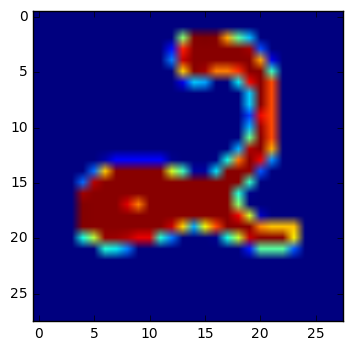

In [20]:
train_images.shape

(2000, 784)

In [21]:
with open('mnist_gradients_64_hidden_first_200.csv', 'ba') as f_handler:
    dw_matrix = np.empty((0,rbm.get_dw_as_vector([mnist.train.images[0]]).shape[0]))
    print(dw_matrix.shape)
    for i in range(train_images.shape[0]):
#         print(mnist.train.labels[i])
        dw_new = rbm.get_dw_as_vector([train_images[i]])
        dw_matrix = np.vstack((dw_matrix, dw_new))
        if i % 100 == 0:
            print('done with: %s' % i)
            np.savetxt(f_handler, dw_matrix)
            dw_matrix = np.empty(dw_matrix.shape)
        

(0, 50176)
done with: 0
done with: 100
done with: 200
done with: 300
done with: 400
done with: 500
done with: 600
done with: 700
done with: 800
done with: 900
done with: 1000
done with: 1100
done with: 1200
done with: 1300
done with: 1400
done with: 1500
done with: 1600
done with: 1700
done with: 1800
done with: 1900


In [114]:
(50 * 1024) / 1.3

39384.61538461538

In [41]:
dw

array([[ -2.19632420e-05,  -2.16513240e-06,  -1.35064749e-06, ...,
         -1.49327316e-05,  -1.19633274e-04,  -1.17322234e-04],
       [ -2.19632420e-05,  -2.16513240e-06,  -1.35064749e-06, ...,
         -1.49327316e-05,  -1.19633274e-04,  -1.17322234e-04],
       [ -3.17564736e-05,  -4.90745208e-07,  -9.91489273e-08, ...,
         -1.88157173e-05,  -2.92381480e-10,  -2.04646631e-06]], dtype=float32)

[ -2.19632420e-05  -2.16513240e-06  -1.35064749e-06 ...,  -1.49327316e-05
  -1.19633274e-04  -1.17322234e-04]
[ 0.99997807  0.99999785  0.99999863 ...,  0.99998504  0.99988037
  0.9998827 ]
[ -2.19347494e-05  -2.14576949e-06  -1.37090774e-06 ...,  -1.49608777e-05
  -1.19633674e-04  -1.17308824e-04]


In [45]:
a = np.asarray([[1,2,3], [4,5,6], [7,8,9]])

with open("foo.csv", 'ab') as f:
    np.savetxt(f, dw, delimiter=',')

In [22]:
import sys
sys.getsizeof(dw_0) / 1024 / 1024 * mnist.test.images.shape[0]

7657.16552734375